<a href="https://colab.research.google.com/github/ziqiveronica/Machine-Learning-Classification-of-Spotify-Music-Genres/blob/main/classification_of_spotify_music_genres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Capstone Project
### Veronica Zhao
### May 5, 2024

# Prepare the Environment

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from scipy.stats import chi2_contingency
from itertools import cycle
from mpl_toolkits.mplot3d import Axes3D

import random
random_seed = 12058959
np.random.seed(random_seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/musicData.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preliminary Data Inspection
Check for columns not in the specified range (0-1 scale or other defined scales).

In [ ]:
print(df.info())
print()
print(df.head())
print()
print(df.describe())
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

In [ ]:
df.columns

Index(['instance_id', 'artist_name', 'track_name', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'obtained_date', 'valence', 'music_genre'],
      dtype='object')

## Heatmap

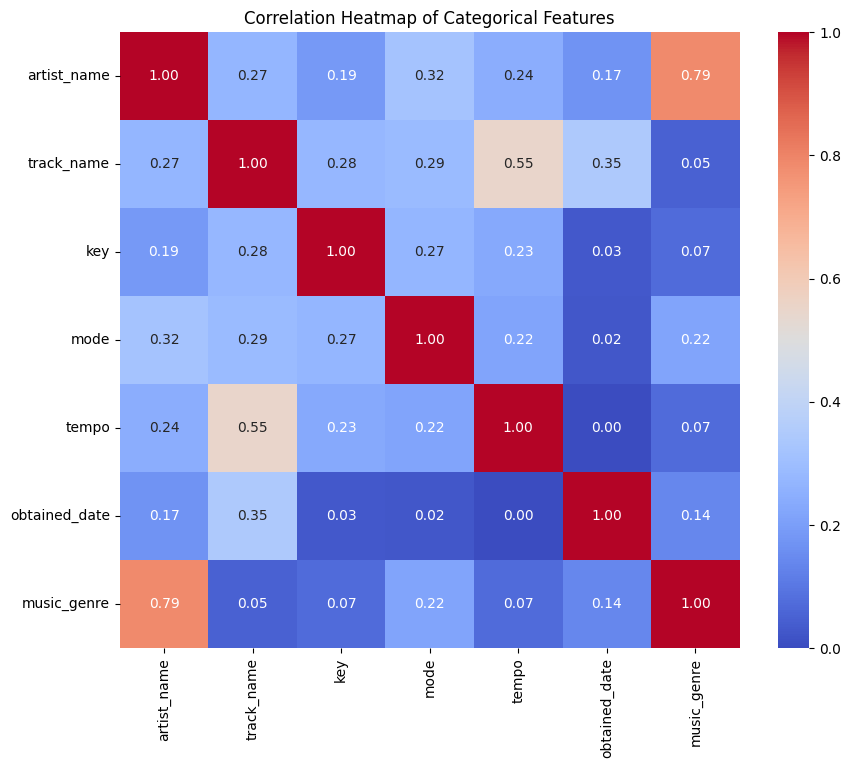

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
corr_cramers_v = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        corr_cramers_v.loc[col1, col2] = cramers_v(df[col1], df[col2])

plt.figure(figsize=(10, 8))
sns.heatmap(corr_cramers_v.astype(float), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of Categorical Features")
plt.show()

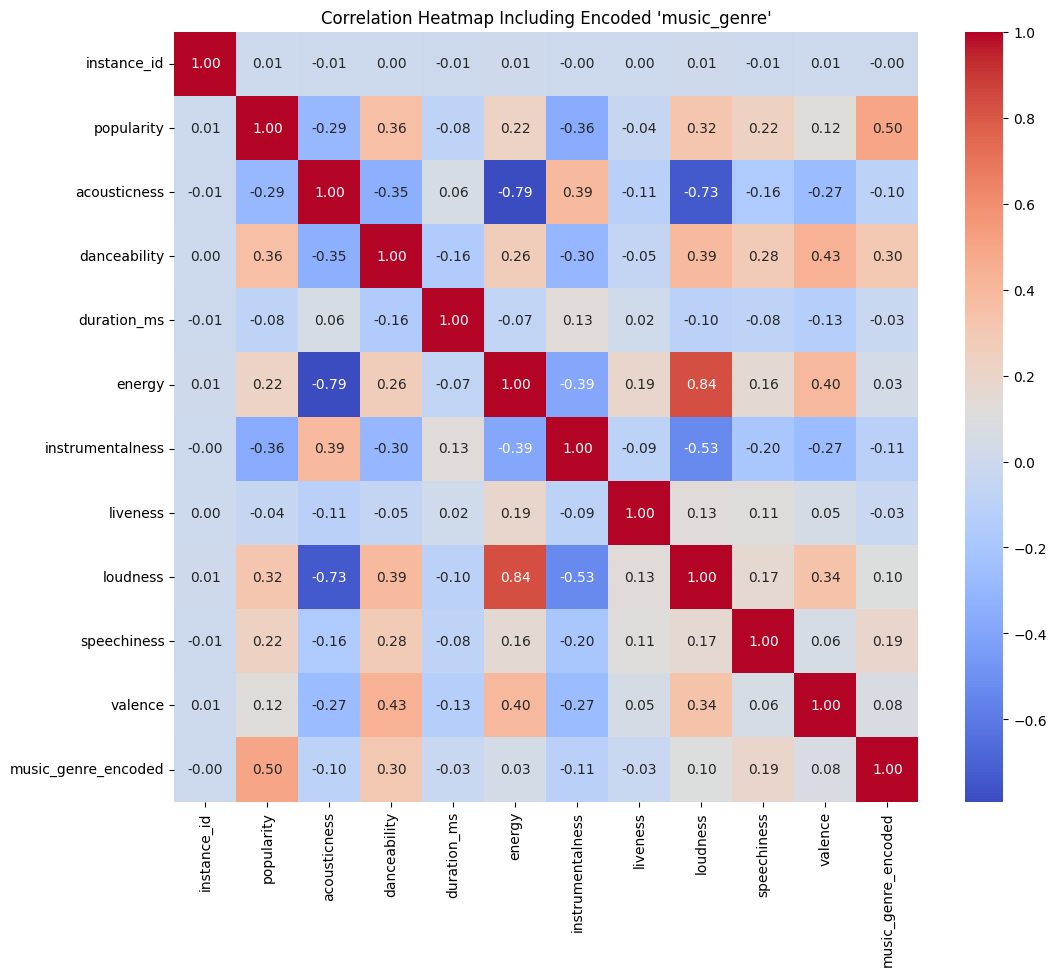

In [ ]:
label_encoder = LabelEncoder()
df['music_genre_encoded'] = label_encoder.fit_transform(df['music_genre'])
numeric_cols = df.select_dtypes(include=[np.number])

corr_matrix = numeric_cols.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap Including Encoded 'music_genre'")
plt.show()

df.drop('music_genre_encoded', axis=1, inplace=True)

In [ ]:
print("\nMissing Values:")
print(df.isnull().sum())

empty_rows = df[df.isnull().any(axis=1) | (df == '').any(axis=1)]
print(empty_rows)

df = df.dropna()
df = df.reset_index(drop=True)
df


Missing Values:
instance_id         5
artist_name         5
track_name          5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
obtained_date       5
valence             5
music_genre         5
dtype: int64
       instance_id artist_name track_name  popularity  acousticness  \
10000          NaN         NaN        NaN         NaN           NaN   
10001          NaN         NaN        NaN         NaN           NaN   
10002          NaN         NaN        NaN         NaN           NaN   
10003          NaN         NaN        NaN         NaN           NaN   
10004          NaN         NaN        NaN         NaN           NaN   

       danceability  duration_ms  energy  instrumentalness  key  liveness  \
10000           NaN          NaN     NaN               NaN  NaN       

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,58878.0,BEXEY,GO GETTA,59.0,0.03340,0.913,-1.0,0.574,0.00000,C#,0.119,-7.022,Major,0.2980,98.02799999999999,4-Apr,0.330,Hip-Hop
49996,43557.0,Roy Woods,Drama (feat. Drake),72.0,0.15700,0.709,251860.0,0.362,0.00000,B,0.109,-9.814,Major,0.0550,122.04299999999999,4-Apr,0.113,Hip-Hop
49997,39767.0,Berner,Lovin' Me (feat. Smiggz),51.0,0.00597,0.693,189483.0,0.763,0.00000,D,0.143,-5.443,Major,0.1460,131.079,4-Apr,0.395,Hip-Hop
49998,57944.0,The-Dream,Shawty Is Da Shit,65.0,0.08310,0.782,262773.0,0.472,0.00000,G,0.106,-5.016,Minor,0.0441,75.88600000000001,4-Apr,0.354,Hip-Hop


# Train/Test Split

In [ ]:
def stratified_split(df, test_size_per_class=500):
    test_df = pd.DataFrame()
    train_df = pd.DataFrame()
    for genre in df['music_genre'].unique():
        genre_group = df[df['music_genre'] == genre]
        genre_test = genre_group.sample(n=test_size_per_class, random_state=random_seed)
        genre_train = genre_group.drop(genre_test.index)
        test_df = pd.concat([test_df, genre_test])
        train_df = pd.concat([train_df, genre_train])
    return train_df, test_df

train_df, test_df = stratified_split(df)

We split the data before any preprocessing or imputation to avoid data leakage. The dataset was successfully partitioned into training and test sets, ensuring equal representation across music genres. Each genre contributes 500 songs to the test set and 4,500 songs to the training set, guaranteeing balanced exposure across styles. This stratification ensures a fair evaluation of the model across a diverse range of musical genres, with a total of 5,000 songs in the test set and 45,000 songs in the training set. This method confirms the robustness of the data preparation process, setting a solid foundation for subsequent modeling stages.

In [ ]:
print("Test set counts by genre:")
print(test_df['music_genre'].value_counts())
print()

print("Training set counts by genre:")
print(train_df['music_genre'].value_counts())
print()

print(f"Total number of songs in the test set: {test_df.shape[0]}")
print(f"Total number of songs in the training set: {train_df.shape[0]}")
print()

Test set counts by genre:
music_genre
Electronic     500
Anime          500
Jazz           500
Alternative    500
Country        500
Rap            500
Blues          500
Rock           500
Classical      500
Hip-Hop        500
Name: count, dtype: int64

Training set counts by genre:
music_genre
Electronic     4500
Anime          4500
Jazz           4500
Alternative    4500
Country        4500
Rap            4500
Blues          4500
Rock           4500
Classical      4500
Hip-Hop        4500
Name: count, dtype: int64

Total number of songs in the test set: 5000
Total number of songs in the training set: 45000



# Data Preprocessing

In [ ]:
train_df.replace('?', np.nan, inplace=True)
print(train_df.isnull().sum())

instance_id            0
artist_name            0
track_name             0
popularity             0
acousticness           0
danceability           0
duration_ms            0
energy                 0
instrumentalness       0
key                    0
liveness               0
loudness               0
mode                   0
speechiness            0
tempo               4491
obtained_date          0
valence                0
music_genre            0
dtype: int64


In the preprocessing of the dataset, an initial check revealed that duration_ms, representing song duration in milliseconds, contained placeholder values of -1 for missing data. To address this, the median duration was calculated from the training data, excluding these placeholders, ensuring no data leakage occurred. This median was then used to replace all -1 values in both the training and test datasets. Additionally, a binary feature, duration_ms_missing, was introduced to indicate where replacements had occurred. This method preserves the integrity of the data and ensures the model's evaluations are both consistent and generalizable, adhering to best practices in machine learning data preparation.

In [ ]:
count_minus_one = df['duration_ms'].value_counts().get(-1, 0)
print(f"Count of '-1' in duration_ms: {count_minus_one}")

median_duration_ms = train_df[train_df['duration_ms'] != -1]['duration_ms'].median()

for df in [train_df, test_df]:
    df['duration_ms_missing'] = (df['duration_ms'] == -1).astype(int)
    df['duration_ms'].replace(-1, median_duration_ms, inplace=True)

Count of '-1' in duration_ms: 4939


In [ ]:
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()

numeric_features = [col for col in numeric_features if col not in ['instance_id', 'music_genre']]
categorical_features = [col for col in categorical_features if col not in ['music_genre']]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

train_X = preprocessor.fit_transform(train_df.drop(['music_genre', 'instance_id'], axis=1))
test_X = preprocessor.transform(test_df.drop(['music_genre', 'instance_id'], axis=1))

label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(train_df['music_genre'])
test_y = label_encoder.transform(test_df['music_genre'])

## Dimension Reduction Visualization

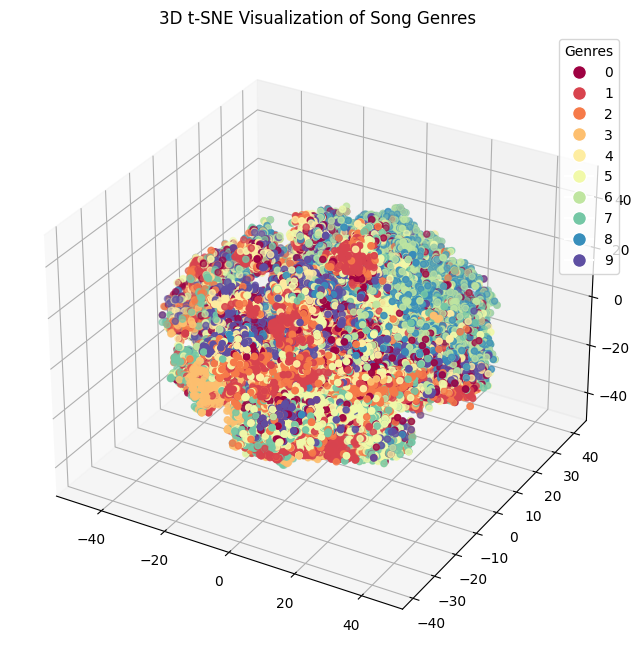

In [ ]:
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)

tsne = TSNE(n_components=3, random_state=random_seed, init='random')

X_tsne = tsne.fit_transform(np.asarray(train_X.todense()))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.Spectral(train_y_encoded.astype(float) / max(train_y_encoded))

scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=colors)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(i),
                          markerfacecolor=plt.cm.Spectral(i / max(train_y_encoded)), markersize=10)
                   for i in np.unique(train_y_encoded)]
ax.legend(handles=legend_elements, title="Genres")

plt.title('3D t-SNE Visualization of Song Genres')
plt.show()


### t-SNE

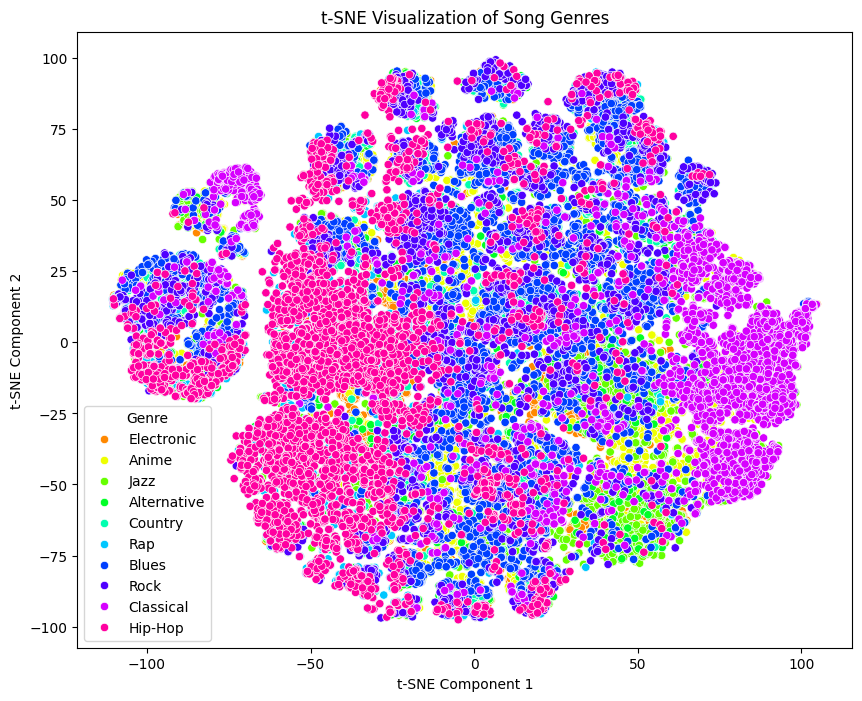

In [ ]:
tsne = TSNE(n_components=2, random_state=random_seed, init='random')
X_tsne = tsne.fit_transform(train_X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=train_y, palette=sns.color_palette("hsv", len(np.unique(train_y))))
plt.title('t-SNE Visualization of Song Genres')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Genre', loc='best')
plt.show()


### TruncatedSVD and t-SNE

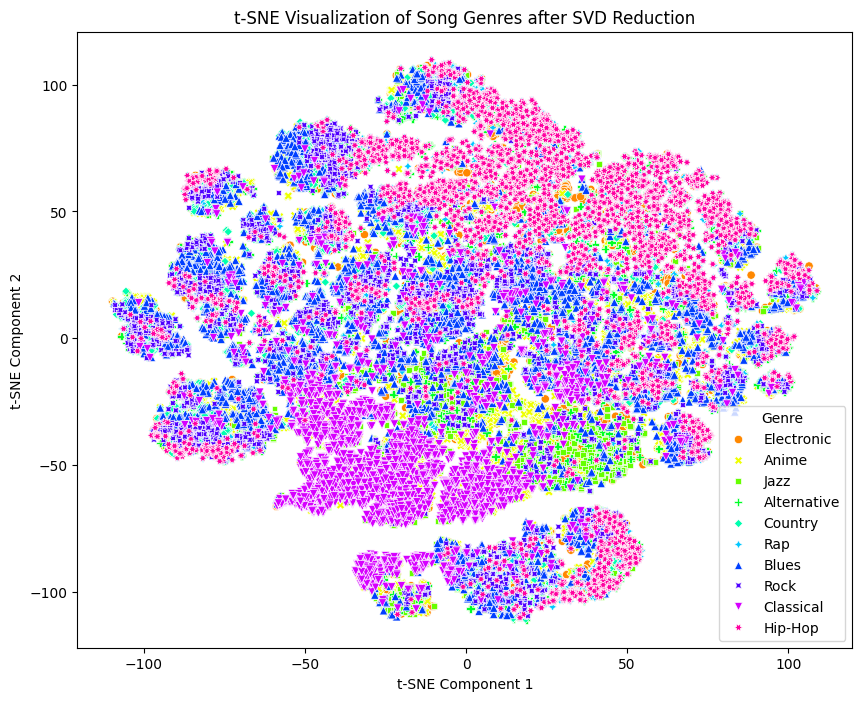

In [ ]:
svd = TruncatedSVD(n_components=50, random_state=random_seed)
X_svd = svd.fit_transform(train_X)

tsne = TSNE(n_components=2, random_state=random_seed, init='random')
X_tsne = tsne.fit_transform(X_svd)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=train_y, style=train_y, palette=sns.color_palette("hsv", len(set(train_y))))
plt.title('t-SNE Visualization of Song Genres after SVD Reduction')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Genre', loc='best')
plt.show()

# Model Training

In [ ]:
models = {
    'Neural Network': Sequential([
        Dense(128, activation='relu', input_dim=train_X.shape[1]),
        Dense(64, activation='relu'),
        Dense(len(np.unique(train_y)), activation='softmax')
    ]),
    'SVM': CalibratedClassifierCV(LinearSVC(dual=False, random_state=random_seed), method='sigmoid', cv=5),
    'Decision Tree': DecisionTreeClassifier(random_state=random_seed),
    'Random Forest': RandomForestClassifier(random_state=random_seed),
    'Gradient Boosting': GradientBoostingClassifier(random_state=random_seed)

}

models['Neural Network'].compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

for name, model in models.items():
    print(f"Training {name}...")
    if name == 'Neural Network':
        model.fit(train_X, train_y, epochs=10, batch_size=32, verbose=0)  # Train with less verbose output
    else:
        model.fit(train_X, train_y)


Training Neural Network...
Training SVM...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...


# Model Evaluation

## Confusion Matrix & Classification Report

------------------------------------  Neural Network Analysis  ------------------------------------

157/157 [==============================] - 0s 2ms/step


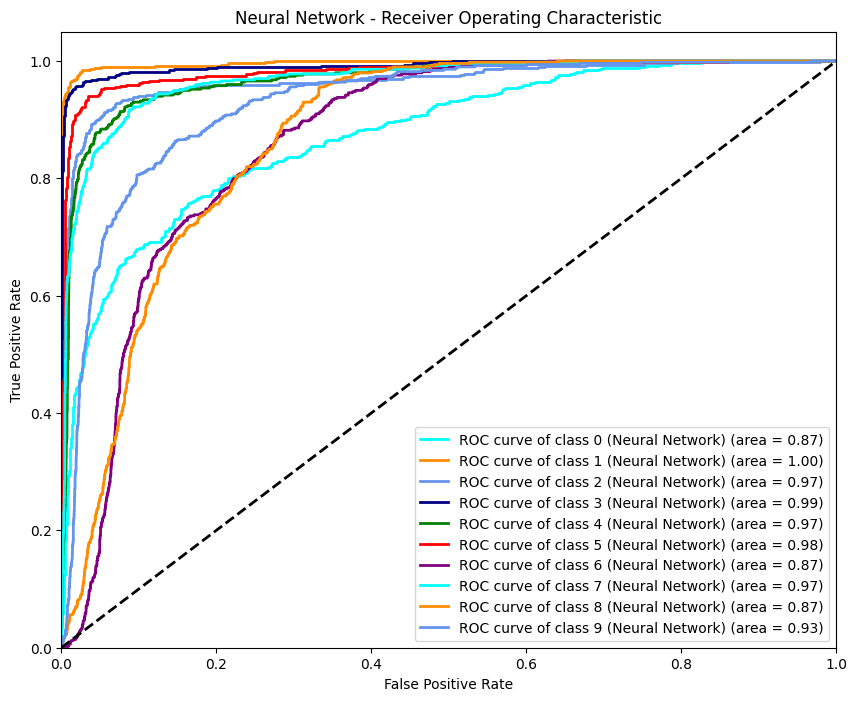


Neural Network - Classification Report
              precision    recall  f1-score   support

           0       0.50      0.62      0.55       500
           1       0.92      0.96      0.94       500
           2       0.83      0.82      0.83       500
           3       0.94      0.92      0.93       500
           4       0.81      0.78      0.80       500
           5       0.93      0.77      0.84       500
           6       0.40      0.49      0.44       500
           7       0.78      0.77      0.78       500
           8       0.36      0.32      0.34       500
           9       0.64      0.58      0.61       500

    accuracy                           0.70      5000
   macro avg       0.71      0.70      0.71      5000
weighted avg       0.71      0.70      0.71      5000



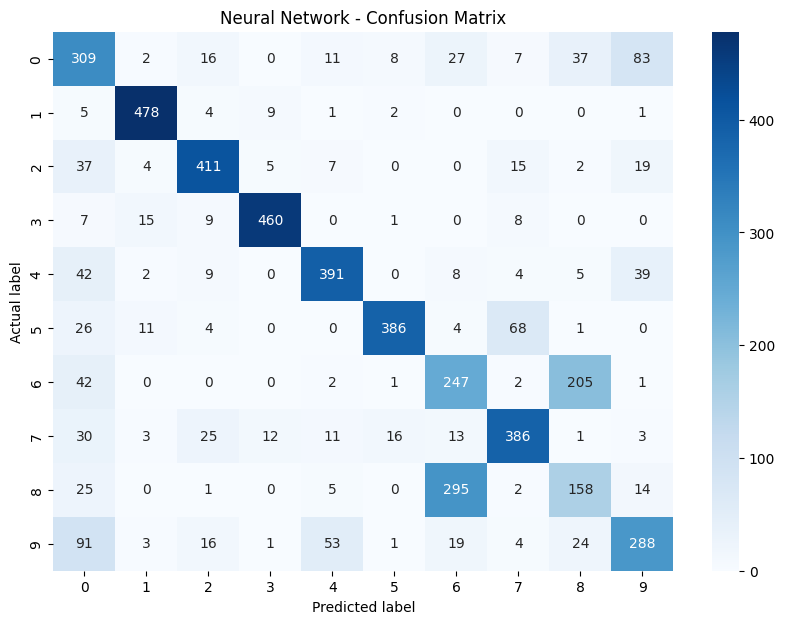



------------------------------------  SVM Analysis  ------------------------------------



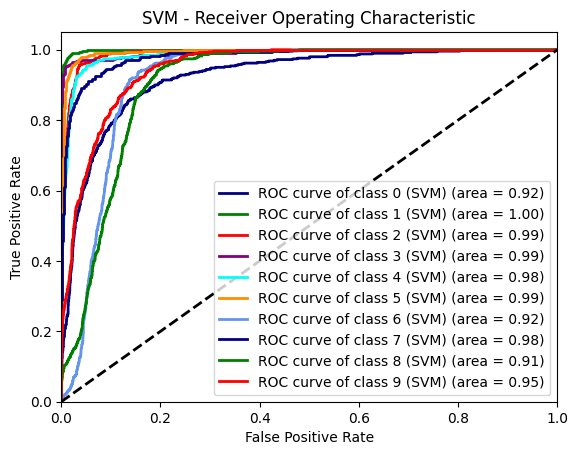


SVM - Classification Report
              precision    recall  f1-score   support

           0       0.59      0.60      0.60       500
           1       0.96      0.96      0.96       500
           2       0.84      0.85      0.84       500
           3       0.93      0.95      0.94       500
           4       0.82      0.84      0.83       500
           5       0.91      0.90      0.90       500
           6       0.40      0.42      0.41       500
           7       0.84      0.80      0.82       500
           8       0.39      0.38      0.39       500
           9       0.63      0.62      0.62       500

    accuracy                           0.73      5000
   macro avg       0.73      0.73      0.73      5000
weighted avg       0.73      0.73      0.73      5000



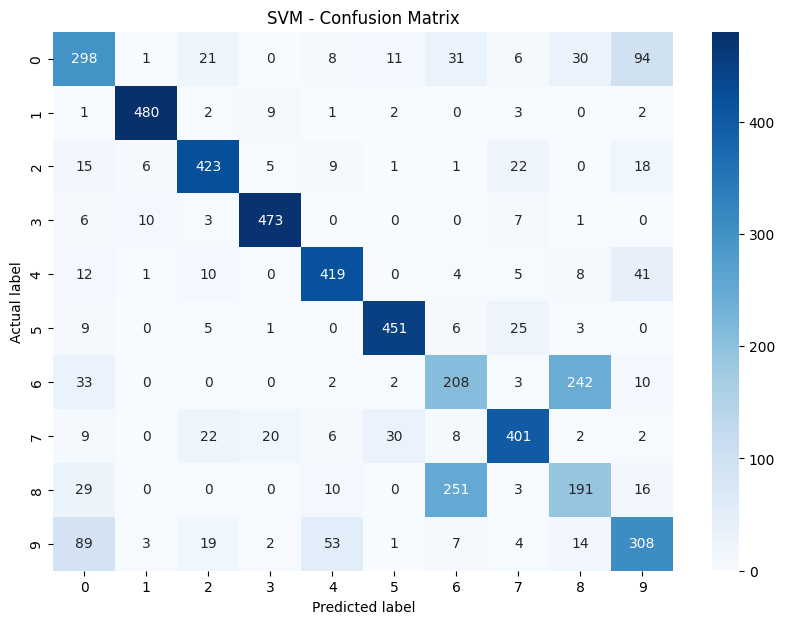



------------------------------------  Decision Tree Analysis  ------------------------------------



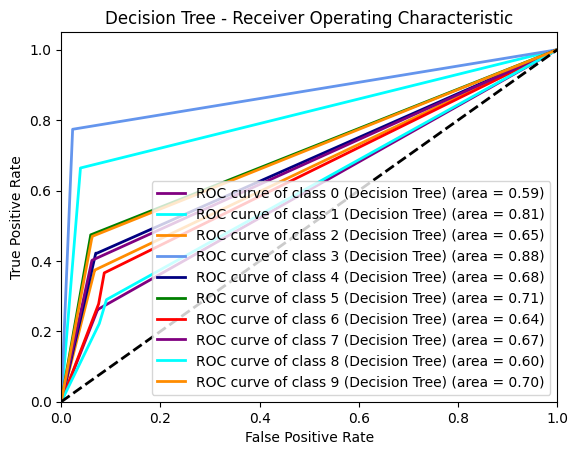


Decision Tree - Classification Report
              precision    recall  f1-score   support

           0       0.28      0.26      0.27       500
           1       0.66      0.66      0.66       500
           2       0.38      0.37      0.38       500
           3       0.79      0.77      0.78       500
           4       0.39      0.42      0.41       500
           5       0.47      0.47      0.47       500
           6       0.32      0.37      0.34       500
           7       0.42      0.40      0.41       500
           8       0.24      0.22      0.23       500
           9       0.46      0.46      0.46       500

    accuracy                           0.44      5000
   macro avg       0.44      0.44      0.44      5000
weighted avg       0.44      0.44      0.44      5000



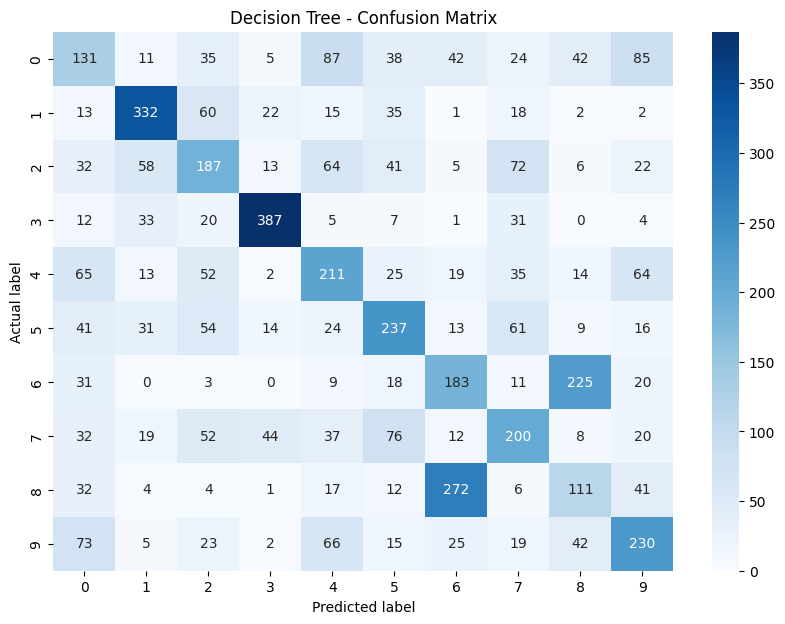



------------------------------------  Random Forest Analysis  ------------------------------------



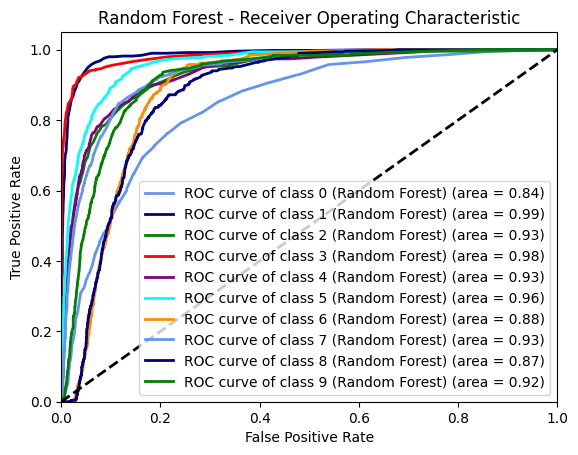


Random Forest - Classification Report
              precision    recall  f1-score   support

           0       0.44      0.35      0.39       500
           1       0.81      0.85      0.83       500
           2       0.64      0.61      0.63       500
           3       0.83      0.89      0.86       500
           4       0.62      0.67      0.65       500
           5       0.71      0.70      0.71       500
           6       0.32      0.37      0.35       500
           7       0.66      0.54      0.59       500
           8       0.31      0.30      0.31       500
           9       0.50      0.56      0.53       500

    accuracy                           0.59      5000
   macro avg       0.59      0.59      0.58      5000
weighted avg       0.59      0.59      0.58      5000



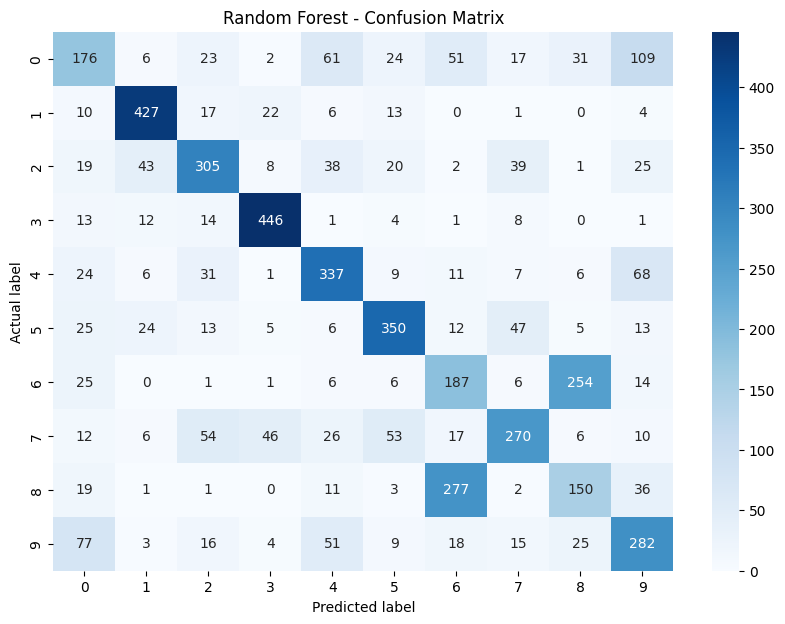



------------------------------------  Gradient Boosting Analysis  ------------------------------------



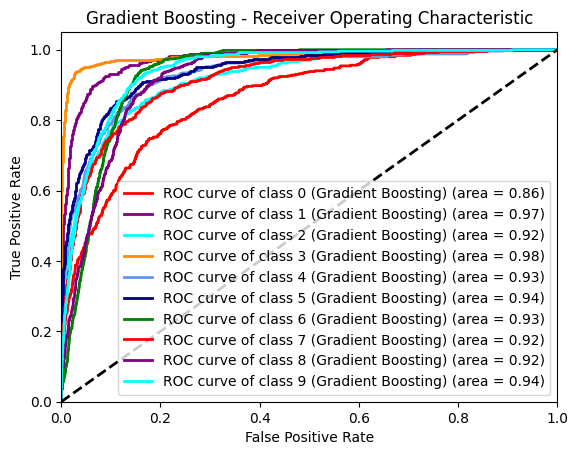


Gradient Boosting - Classification Report
              precision    recall  f1-score   support

           0       0.48      0.43      0.45       500
           1       0.78      0.74      0.76       500
           2       0.61      0.57      0.59       500
           3       0.85      0.91      0.88       500
           4       0.62      0.60      0.61       500
           5       0.71      0.63      0.67       500
           6       0.46      0.59      0.51       500
           7       0.56      0.61      0.58       500
           8       0.48      0.34      0.40       500
           9       0.54      0.67      0.60       500

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.60      5000
weighted avg       0.61      0.61      0.60      5000



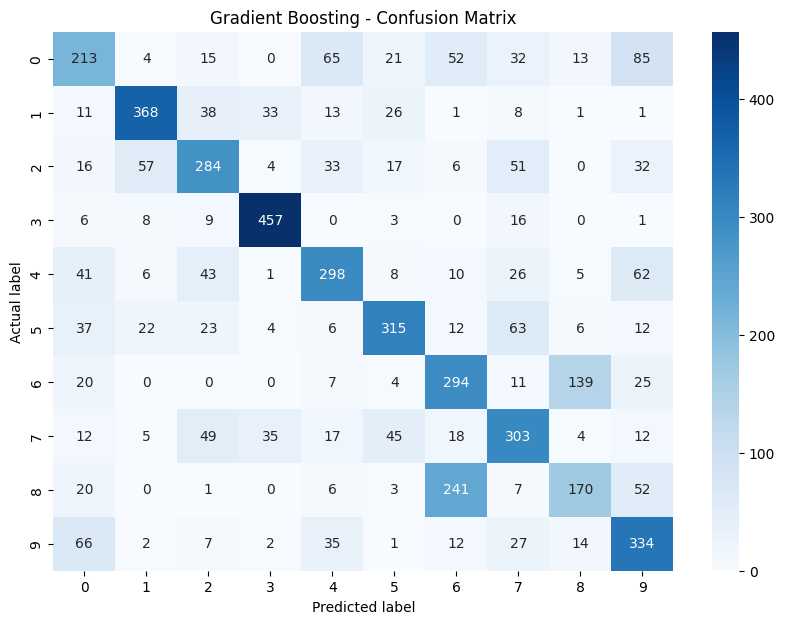

In [ ]:
y_bin = label_binarize(test_y, classes=np.unique(test_y))
n_classes = y_bin.shape[1]

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'green', 'red', 'purple'])
plt.figure(figsize=(10, 8))

for name, model in models.items():

    print(f"------------------------------------  {name} Analysis  ------------------------------------")
    print()

    if name == 'Neural Network':
        probs = model.predict(test_X)
        preds = np.argmax(probs, axis=1)
    else:
        probs = model.predict_proba(test_X)
        preds = np.argmax(probs, axis=1)

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=next(colors), lw=2,
                 label=f'ROC curve of class {i} ({name}) (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{name} - Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()

    print(f"\n{name} - Classification Report")
    print(classification_report(test_y, preds))

    cm = confusion_matrix(test_y, preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    print()
    print()

## Micro-average ROC & Macro-average ROC

157/157 [==============================] - 0s 2ms/step


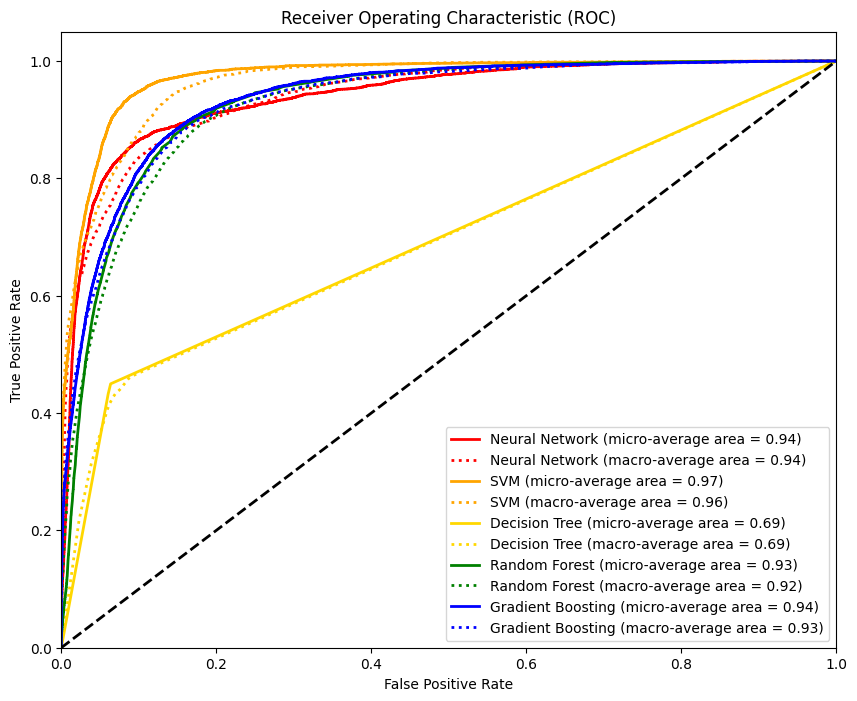

In [ ]:
y_bin = label_binarize(test_y, classes=np.unique(test_y))
n_classes = y_bin.shape[1]

colors = cycle(['red', 'red', 'orange', 'orange', 'gold','gold', 'green', 'green','blue', 'blue'])
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if name == 'Neural Network':
        probs = model.predict(test_X)
    else:
        probs = model.predict_proba(test_X)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.plot(fpr["micro"], tpr["micro"],
             color=next(colors), linestyle='-', linewidth=2,
             label=f'{name} (micro-average area = {roc_auc["micro"]:.2f})')

    plt.plot(all_fpr, mean_tpr,
             color=next(colors), linestyle=':', linewidth=2,
             label=f'{name} (macro-average area = {roc_auc["macro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


Interesting observation: Even though our dataset had an equal number of instances for each class (500 per class), we observed differing micro-average and macro-average ROC AUC values.

The micro-average, which aggregates outcomes from all classes, showed higher AUC values, reflecting robust overall model performance across all classes combined. Conversely, the macro-average, calculated independently for each class and then averaged, highlighted significant performance disparities across classes. These findings are substantiated by the classification reports that show variations in precision, recall, and F1-scores across different classes (e.g., class 0 at 0.45 and class 3 at 0.88 F1-score for Gradient Boosting). Such differences underline the importance of using both micro and macro averages to gain a comprehensive view of a model's performance: micro-averages for overall effectiveness and macro-averages for insights into class-specific performance.

## Feature Importance Analysis

In [ ]:
original_train_X = train_df.drop(['music_genre', 'instance_id'], axis=1)

if hasattr(original_train_X, 'columns'):
    feature_names = original_train_X.columns
else:
    feature_names = [f'feature_{i}' for i in range(train_X.shape[1])]

for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        best_predictor_index = np.argmax(feature_importances)
        best_predictor = feature_names[best_predictor_index]
        best_predictor_importance = feature_importances[best_predictor_index]

        print(f"Best predictor for {name}: {best_predictor}")
        print(f"Importance of {best_predictor}: {best_predictor_importance}")

    else:
        print(f"No direct feature importance available for {name}.")

No direct feature importance available for Neural Network.
No direct feature importance available for SVM.
Best predictor for Decision Tree: artist_name
Importance of artist_name: 0.15910949380640177
Best predictor for Random Forest: artist_name
Importance of artist_name: 0.05835865223814753
Best predictor for Gradient Boosting: artist_name
Importance of artist_name: 0.2634997108262129
